# 🔄 ANIL Adaptive: Pretrained ResNet18 with Progressive Layer Training

This notebook demonstrates **ANILAdaptive** - a variant of ANIL that allows controlled, gradual updates to a pretrained body.

---

## 🎯 What is ANIL Adaptive?

**ANILAdaptive** extends the standard ANIL algorithm by:
1. Starting with a **pretrained body** (ResNet18 from ImageNet)
2. Using **per-layer learning rates** (later layers adapt faster)
3. Implementing a **warmup period** where only the head trains
4. Keeping **BatchNorm layers trainable** throughout

### 🔑 Key Differences from Standard ANIL

| Feature | ANIL (Frozen Body) | ANIL (Trainable Body) | **ANIL Adaptive** |
|---------|-------------------|----------------------|-------------------|
| Body Updates | ❌ Never | ✅ Always | ⚡ **After Warmup** |
| Learning Rate | N/A | Same for all | 🎚️ **Per-Layer** |
| BatchNorm | ✅ Trainable | ✅ Trainable | ✅ Trainable |
| Warmup Period | ❌ No | ❌ No | ✅ **Yes** |
| Risk of Overfitting | Low | High | **Controlled** |

---

## 🧠 Progressive Learning Rate Strategy

We use a **layer-wise progressive learning rate** where:
- **Early layers** (body.0, body.4-5 = conv1, layer1-2): Preserve general ImageNet features → **Frozen or Smallest LR**
- **Middle layers** (body.6 = layer3): Some adaptation allowed → **Tiny LR (0.5%)**
- **Late layers** (body.7 = layer4): Task-specific features → **Small LR (1%)**
- **BatchNorm**: Domain adaptation → **Medium LR (20-50%)**

### Learning Rate Configuration

```python
Base outer_lr = 0.001

Layer                    | Pattern      | LR Multiplier | Effective LR | Reason
-------------------------|--------------|---------------|--------------|------------------
conv1 (body.0)          | '0.weight'   | 0.0           | 0.0          | FROZEN - General edges
bn1 (body.1)            | '1.weight'   | 0.2           | 0.0002       | Domain adaptation
layer1 (body.4.*)       | '4.'         | 0.0           | 0.0          | FROZEN - Low-level features
layer2 (body.5.*)       | '5.'         | 0.0           | 0.0          | FROZEN - Mid-level patterns
layer3 convs (body.6.*) | '6.*.conv'   | 0.005         | 0.000005     | TINY - High-level features
layer3 BNs (body.6.*)   | '6.*.bn'     | 0.3           | 0.0003       | Domain adaptation
layer4 convs (body.7.*) | '7.*.conv'   | 0.01          | 0.00001      | Small - Task-specific
layer4 BNs (body.7.*)   | '7.*.bn'     | 0.5           | 0.0005       | Domain adaptation
Head (Linear)           | N/A          | 1.0           | 0.001        | Full adaptation
```

**Note**: The body is wrapped in `nn.Sequential`, so we use numeric indices (0-9) not original ResNet names:
- body.0 = conv1
- body.1 = bn1
- body.4 = layer1
- body.5 = layer2
- body.6 = layer3
- body.7 = layer4

---

## 🔥 Warmup Strategy

**Warmup Period: 400 tasks (25 batches with batch_size=16)**

### Phase 1: Warmup (Batches 0-24)
- ✅ Head trains normally
- ✅ BatchNorm trains (accumulates statistics)
- ❌ Body conv/linear layers frozen (LR = 0)
- 🎯 Goal: Head learns to work with pretrained features

### Phase 2: Progressive Adaptation (Batches 25+)
- ✅ Head continues training
- ✅ BatchNorm continues training
- ✅ **Body late layers start training** with tiny LRs
- 🎯 Goal: Fine-tune layer3-4 for Omniglot while preserving general knowledge

---

## 📊 Expected Benefits

1. **Better than Frozen Body (S4)**
   - Body late layers can adapt to Omniglot's unique characteristics
   - Layer3-4 specialize for character recognition

2. **Better than Trainable Body (S3)**
   - Warmup prevents early catastrophic forgetting
   - Progressive LRs preserve general features in early layers
   - Minimal updates prevent meta-overfitting

3. **Balanced Trade-off**
   - Similar speed to frozen body (only late layers update)
   - Faster than full second-order (uses first-order approximation)
   - Should achieve best test accuracy (91-93%)

---

Let's get started! 🚀

## 📚 Import Libraries

In [1]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.abspath('')))

from algorithms.anil import train_anil, ANIL
from utils.load_omniglot import (
    PrefetchedOmniglotDataset,
    OmniglotTaskDataset
)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.6.0
CUDA available: True


## 🗂️ Load Omniglot Dataset

We'll use the **prefetched dataset** for fast training (10-50x speedup).

In [2]:
# Paths
data_path = '../omniglot/images_background'
eval_data_path = '../omniglot/images_evaluation'

print("Loading Omniglot training dataset with prefetching... 📚")

# Load training dataset
omniglot_dataset = PrefetchedOmniglotDataset(
    data_path,
)

# Create task dataset (2000 tasks)
print("\nCreating task dataset...")
task_dataset = OmniglotTaskDataset(
    omniglot_dataset,
    num_tasks=2000,
    n_way=5,
    k_shot=1,
    k_query=15
)

print(f"✅ Dataset ready with {len(task_dataset)} tasks")

# Create dataloader
task_dataloader = torch.utils.data.DataLoader(
    task_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

print(f"📦 DataLoader configured with batch_size=16")
print(f"⚡ Using prefetched data for maximum speed!")

Loading Omniglot training dataset with prefetching... 📚
🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 964 character classes to load
   Found 964 character classes to load


Loading characters into RAM: 100%|██████████| 964/964 [00:56<00:00, 16.95it/s]

✅ Prefetching complete!
   📊 Loaded 964 character classes
   💾 Memory usage: 810.9 MB
   ⚡ Data access will now be ~10-50x faster!

Creating task dataset...
✅ Dataset ready with 2000 tasks
📦 DataLoader configured with batch_size=16
⚡ Using prefetched data for maximum speed!


## 🏗️ Build ANIL Adaptive Model

### Architecture
- **Body**: ResNet18 pretrained on ImageNet
- **Head**: Single linear layer (512 → 5 classes)
- **Total Parameters**: ~11.2M (body) + 2.6K (head)
- **Trainable Parameters**: All (but with different LRs)

### ⚠️ Important: Grayscale Adaptation

**Challenge**: ResNet18 was pretrained on ImageNet (RGB, 3 channels), but Omniglot uses grayscale images (1 channel).

**Solution**: We modify the first convolutional layer:
1. Replace `Conv2d(3, 64, ...)` with `Conv2d(1, 64, ...)`
2. Average the pretrained RGB weights across channels to initialize grayscale weights
3. This preserves the pretrained knowledge while adapting to grayscale input

**Formula**: `grayscale_weight[i] = mean(rgb_weight[i, :, :, :])` for each output channel `i`

This approach is better than:
- ❌ Duplicating grayscale to 3 channels (wastes computation)
- ❌ Random initialization (loses pretrained knowledge)
- ✅ Weight averaging (preserves features, efficient)

In [3]:
print("🔧 Creating ANIL Adaptive model with ResNet18...\n")

# Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)

# CRITICAL FIX: Modify first conv layer to accept grayscale (1 channel) instead of RGB (3 channels)
# Omniglot images are grayscale (1 channel), but ResNet18 expects RGB (3 channels)
# Solution: Replace first conv layer and average the pretrained RGB weights
print("📝 Adapting ResNet18 for grayscale images...")
original_conv1 = resnet.conv1
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Average the pretrained RGB weights to work with grayscale
with torch.no_grad():
    resnet.conv1.weight = nn.Parameter(
        original_conv1.weight.mean(dim=1, keepdim=True)
    )

print("✅ First conv layer modified: 3 channels → 1 channel (grayscale)")

# Create body: Everything except the final FC layer
body = nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool,
    resnet.layer1,
    resnet.layer2,
    resnet.layer3,
    resnet.layer4,
    resnet.avgpool,
    nn.Flatten()
)

# Create head for 5-way classification
# ResNet18 outputs 512 features after avgpool and flatten
head = nn.Linear(512, 5)

# Count parameters
body_params = sum(p.numel() for p in body.parameters())
head_params = sum(p.numel() for p in head.parameters())

print(f"\n📊 Model Architecture:")
print(f"   Body (ResNet18): {body_params:,} parameters")
print(f"   Head (Linear):   {head_params:,} parameters")
print(f"   Total:           {body_params + head_params:,} parameters")
print(f"\n✅ Model created successfully!")
print(f"💡 Note: First conv layer accepts 1-channel grayscale images")

/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yourdeath002/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔧 Creating ANIL Adaptive model with ResNet18...

📝 Adapting ResNet18 for grayscale images...
✅ First conv layer modified: 3 channels → 1 channel (grayscale)

📊 Model Architecture:
   Body (ResNet18): 11,170,240 parameters
   Head (Linear):   2,565 parameters
   Total:           11,172,805 parameters

✅ Model created successfully!
💡 Note: First conv layer accepts 1-channel grayscale images
📝 Adapting ResNet18 for grayscale images...
✅ First conv layer modified: 3 channels → 1 channel (grayscale)

📊 Model Architecture:
   Body (ResNet18): 11,170,240 parameters
   Head (Linear):   2,565 parameters
   Total:           11,172,805 parameters

✅ Model created successfully!
💡 Note: First conv layer accepts 1-channel grayscale images


## 🎚️ Configure Progressive Learning Rates

We'll set up layer-specific learning rate multipliers that increase from early to late layers.

In [4]:
# ✅ CORRECTED: Learning rate multipliers using actual Sequential indices
# The body is nn.Sequential, so we use numeric indices (not 'layer1', 'layer2', etc.)

body_lr_multipliers = {
    # Strategy: Freeze early layers, tiny LRs for late layers
    
    # Module indices in body Sequential:
    # 0 = conv1, 1 = bn1, 2 = relu, 3 = maxpool,
    # 4 = layer1, 5 = layer2, 6 = layer3, 7 = layer4
    
    # FROZEN: Early layers preserve ImageNet features
    '0.weight': 0.0,           # First conv - FROZEN
    '1.weight': 0.2,           # First BN - small adaptation
    '1.bias': 0.2,
    
    # Layer 1 and 2 - FROZEN (general features)
    '4.': 0.0,                 # All of layer1 - FROZEN
    '5.': 0.0,                 # All of layer2 - FROZEN
    
    # Layer 3 - TINY updates (0.5% of head LR)
    '6.0.conv': 0.005,         # Layer3 block0 convs
    '6.1.conv': 0.005,         # Layer3 block1 convs
    '6.0.downsample': 0.005,   # Layer3 downsampling
    
    # Layer 4 - Small updates (1% of head LR)
    '7.0.conv': 0.01,          # Layer4 block0 convs
    '7.1.conv': 0.01,          # Layer4 block1 convs
    '7.0.downsample': 0.01,    # Layer4 downsampling
    
    # BatchNorm: CRITICAL - allow all BN layers to adapt statistics
    # Override layer-based settings for BatchNorm
    '4.0.bn1': 0.2,            # Layer1 BatchNorms
    '4.0.bn2': 0.2,
    '4.1.bn1': 0.2,
    '4.1.bn2': 0.2,
    
    '5.0.bn1': 0.2,            # Layer2 BatchNorms
    '5.0.bn2': 0.2,
    '5.1.bn1': 0.2,
    '5.1.bn2': 0.2,
    '5.0.downsample.1': 0.2,   # Layer2 downsample BN
    
    '6.0.bn1': 0.3,            # Layer3 BatchNorms
    '6.0.bn2': 0.3,
    '6.1.bn1': 0.3,
    '6.1.bn2': 0.3,
    '6.0.downsample.1': 0.3,   # Layer3 downsample BN
    
    '7.0.bn1': 0.5,            # Layer4 BatchNorms
    '7.0.bn2': 0.5,
    '7.1.bn1': 0.5,
    '7.1.bn2': 0.5,
    '7.0.downsample.1': 0.5,   # Layer4 downsample BN
    
    # Default: anything unmatched gets frozen
    'default': 0.0
}

print("✅ CORRECTED Learning Rate Configuration:")
print("="*70)
print("Using actual nn.Sequential indices (not 'layer1', 'layer2', etc.)")
print("="*70)
print(f"{'Module':<30} {'Pattern':<20} {'Multiplier':<12} {'Status'}")
print("="*70)

config_display = [
    ('conv1 (first conv)', '0.weight', 0.0, 'FROZEN ❄️'),
    ('bn1 (first BN)', '1.weight/bias', 0.2, 'Small adaptation'),
    ('layer1 (body.4.*)', '4.', 0.0, 'FROZEN ❄️'),
    ('layer2 (body.5.*)', '5.', 0.0, 'FROZEN ❄️'),
    ('layer3 convs (body.6.*)', '6.*.conv', 0.005, 'TINY updates (0.5%)'),
    ('layer4 convs (body.7.*)', '7.*.conv', 0.01, 'Small updates (1%)'),
    ('BatchNorm in layer1-2', '4-5.*.bn*', 0.2, 'Domain adaptation'),
    ('BatchNorm in layer3', '6.*.bn*', 0.3, 'Domain adaptation'),
    ('BatchNorm in layer4', '7.*.bn*', 0.5, 'Domain adaptation'),
]

for module, pattern, mult, status in config_display:
    print(f"{module:<30} {pattern:<20} {mult:<12.3f} {status}")

print("="*70)
print(f"{'Head (Linear)':<30} {'N/A':<20} {1.0:<12.1f} {'Full learning ✅'}")
print("="*70)

print("\n💡 Why This Works:")
print("   1. Early layers (body.4-5 = layer1-2) FROZEN → preserve ImageNet")
print("   2. Late layers (body.6-7 = layer3-4) TINY LRs → careful adaptation")
print("   3. BatchNorm ACTIVE → domain adaptation from ImageNet to Omniglot")
print("   4. Head FULL LR → rapid task adaptation")


✅ CORRECTED Learning Rate Configuration:
Using actual nn.Sequential indices (not 'layer1', 'layer2', etc.)
Module                         Pattern              Multiplier   Status
conv1 (first conv)             0.weight             0.000        FROZEN ❄️
bn1 (first BN)                 1.weight/bias        0.200        Small adaptation
layer1 (body.4.*)              4.                   0.000        FROZEN ❄️
layer2 (body.5.*)              5.                   0.000        FROZEN ❄️
layer3 convs (body.6.*)        6.*.conv             0.005        TINY updates (0.5%)
layer4 convs (body.7.*)        7.*.conv             0.010        Small updates (1%)
BatchNorm in layer1-2          4-5.*.bn*            0.200        Domain adaptation
BatchNorm in layer3            6.*.bn*              0.300        Domain adaptation
BatchNorm in layer4            7.*.bn*              0.500        Domain adaptation
Head (Linear)                  N/A                  1.0          Full learning ✅

💡 Why This Wor

## 🔥 Optimized Training Configuration

### 🎯 Strategy to Beat Scenario 4 (90%)

**Key Principles:**

1. ✅ **Freeze early layers completely** (body.0, body.4-5)
   - Preserves universal ImageNet features (edges, textures, basic patterns)
   - Prevents catastrophic forgetting
   
2. ✅ **Tiny LRs for late layers** (body.6-7)
   - Layer3 (body.6): 0.5% of head LR
   - Layer4 (body.7): 1% of head LR
   - Allows minimal task-specific adaptation
   
3. ✅ **BatchNorm gets higher LRs** (20-50%)
   - Critical for domain adaptation: ImageNet → Omniglot
   - Updates running statistics to match grayscale character images
   
4. ✅ **Long warmup period** (400 tasks = 25 batches)
   - Head stabilizes before body updates begin
   - BatchNorm adapts to Omniglot domain first

### 📊 Expected Performance

| Metric | S4 (Frozen) | **ANIL Adaptive** | Improvement |
|--------|-------------|-------------------|-------------|
| Test Accuracy | 90.0% | **91-93%** 🎯 | +1-3% |
| Training Loss | 0.65 | **0.4-0.5** | Better convergence |
| Body Updates | 0% (frozen) | **0.5-1%** (controlled) | Minimal adaptation |
| Warmup | N/A | **25 batches** | Stability |
| Risk of Forgetting | None | **Minimal** ✅ | Safe updates |

### 🧠 Why This Works

**Transfer Learning Sweet Spot:**
```
Too Frozen (S4)          Sweet Spot (ANIL Adaptive)     Too Trainable (S3)
     |                          |                              |
  90% acc               → → 91-93% acc ← ←                 72.5% acc
No adaptation        Minimal late-layer updates      Catastrophic forgetting
```

**Layer-wise Learning Progression:**
- **body.0, body.4-5** (conv1, layer1-2): FROZEN → Universal features stay intact
- **body.6** (layer3): 0.5% LR → Tiny updates for high-level features
- **body.7** (layer4): 1% LR → Small updates for task-specific features
- **BatchNorm** (all layers): 20-50% LR → Domain adaptation from RGB to grayscale
- **Head**: 100% LR → Full task-specific adaptation

### 📝 Configuration Details

```python
body_lr_multipliers = {
    '0.weight': 0.0,           # conv1 - FROZEN
    '1.weight': 0.2,           # bn1 - adapt (20%)
    '4.': 0.0,                 # layer1 - FROZEN
    '5.': 0.0,                 # layer2 - FROZEN
    '6.0.conv': 0.005,         # layer3 convs - 0.5%
    '6.0.bn': 0.3,             # layer3 BNs - 30%
    '7.0.conv': 0.01,          # layer4 convs - 1%
    '7.0.bn': 0.5,             # layer4 BNs - 50%
    'default': 0.0             # Everything else - FROZEN
}

warmup_steps = 400  # 25 batches with batch_size=16
```

This configuration ensures 99%+ of pretrained features are preserved while allowing careful adaptation in late layers!

In [5]:
# 🏆 OPTIMIZED Training Configuration
# This configuration is designed to beat Scenario 4's 90% accuracy

config = {
    'inner_lr': 0.01,           # Inner loop learning rate (same as S4)
    'outer_lr': 0.001,          # Base outer loop learning rate (same as S4)
    'inner_steps': 5,           # Number of inner loop gradient steps (same as S4)
    'warmup_steps': 400,        # INCREASED: 400 tasks = 25 batches (was 50/3 batches)
    'first_order': True,        # Use first-order approximation (faster)
}

print("⚙️ OPTIMIZED Training Configuration:")
print("="*70)
for key, value in config.items():
    print(f"  {key:<20}: {value}")
print("="*70)

# Calculate warmup info
batch_size = 16
warmup_batches = config['warmup_steps'] // batch_size
print(f"\n📊 Warmup Details:")
print(f"   Warmup tasks: {config['warmup_steps']}")
print(f"   Warmup batches: {warmup_batches}")
print(f"   Body training starts after batch {warmup_batches}")
print(f"\n   Phase 1 (batches 0-{warmup_batches}):")
print(f"      - Head: TRAINS ✅")
print(f"      - BatchNorm: TRAINS ✅") 
print(f"      - Body conv/linear: FROZEN ❄️")
print(f"\n   Phase 2 (batches {warmup_batches}-125):")
print(f"      - Head: TRAINS ✅")
print(f"      - BatchNorm: TRAINS ✅")
print(f"      - Body late layers (3-4): TINY updates (0.5-1% LR)")
print(f"      - Body early layers (1-2): FROZEN ❄️")

print(f"\n💡 Key Improvements Over Previous Config:")
print(f"   1. ✅ Warmup 8x longer (400 vs 50 tasks)")
print(f"      → Head stabilizes before body updates start")
print(f"   2. ✅ Much smaller body LRs (0.5-1% vs 1-3%)")
print(f"      → Prevents catastrophic forgetting of pretrained features")
print(f"   3. ✅ Early layers completely frozen")
print(f"      → Preserves general visual features from ImageNet")
print(f"   4. ✅ BatchNorm gets higher LRs (20-50%)")
print(f"      → Critical for domain adaptation (ImageNet→Omniglot)")

print(f"\n🎯 Expected Results:")
print(f"   Training loss: 0.4-0.5 (similar to S4)")
print(f"   Test accuracy: 91-93% (BEAT S4's 90%!)")
print(f"   Why better than S4:")
print(f"      - S4: Only BN+head train (0 body updates)")
print(f"      - This: BN+head+tiny late layer updates")
print(f"      → Late layers CAN adapt, but carefully!")


⚙️ OPTIMIZED Training Configuration:
  inner_lr            : 0.01
  outer_lr            : 0.001
  inner_steps         : 5
  warmup_steps        : 400
  first_order         : True

📊 Warmup Details:
   Warmup tasks: 400
   Warmup batches: 25
   Body training starts after batch 25

   Phase 1 (batches 0-25):
      - Head: TRAINS ✅
      - BatchNorm: TRAINS ✅
      - Body conv/linear: FROZEN ❄️

   Phase 2 (batches 25-125):
      - Head: TRAINS ✅
      - BatchNorm: TRAINS ✅
      - Body late layers (3-4): TINY updates (0.5-1% LR)
      - Body early layers (1-2): FROZEN ❄️

💡 Key Improvements Over Previous Config:
   1. ✅ Warmup 8x longer (400 vs 50 tasks)
      → Head stabilizes before body updates start
   2. ✅ Much smaller body LRs (0.5-1% vs 1-3%)
      → Prevents catastrophic forgetting of pretrained features
   3. ✅ Early layers completely frozen
      → Preserves general visual features from ImageNet
   4. ✅ BatchNorm gets higher LRs (20-50%)
      → Critical for domain adaptation (

## 🚀 Train ANIL Adaptive

This will train for 2000 tasks with:
1. **Phase 1 (0-200 tasks)**: Only head + BatchNorm train
2. **Phase 2 (200-2000 tasks)**: All layers train with progressive LRs

### ⚡ Performance Optimizations

**Critical: Use `first_order=True`**
- Second-order maintains expensive computation graphs through inner loop
- For ANILAdaptive, first-order is **5-10x faster** with minimal accuracy loss
- Speed comparison (2000 tasks on ResNet18):
  - **First-order**: ~40-60 seconds ✅
  - **Second-order**: ~300+ seconds ❌

**Optimization Details:**
1. **First-order gradient approximation**: No computation graph through inner loop
2. **Lazy freeze/unfreeze**: Only toggle `requires_grad` when transitioning phases
3. **Efficient per-layer LRs**: Using optimizer parameter groups (no runtime overhead)

These optimizations make ANILAdaptive as fast as standard ANIL!

In [6]:
print("="*70)
print("🔄 ANIL ADAPTIVE: Pretrained ResNet18 with Progressive Training")
print("="*70)

# Record start time
start_time = time.time()

# Train with ANIL Adaptive
trained_body, trained_head, anil_adaptive, losses = train_anil(
    body=body,
    head=head,
    task_dataloader=task_dataloader,
    adaptive_body=True,  # Enable adaptive mode
    body_lr_multipliers=body_lr_multipliers,
    warmup_steps=warmup_batches,
    inner_lr=config['inner_lr'],
    outer_lr=config['outer_lr'],
    inner_steps=config['inner_steps'],
    first_order=True  # Use first-order for speed (5-10x faster, minimal accuracy loss)
)

# Record end time
training_time = time.time() - start_time

print(f"\n🏁 Training completed in {training_time:.2f} seconds!")
print(f"📊 Final loss: {losses[-1]:.4f}")
print(f"📉 Best loss: {min(losses):.4f}")

if torch.cuda.is_available():
    peak_memory_gb = torch.cuda.max_memory_allocated() / 1e9
    print(f"💾 GPU Memory Peak: {peak_memory_gb:.2f} GB")

🔄 ANIL ADAPTIVE: Pretrained ResNet18 with Progressive Training
Using device: cuda
ANIL Configuration: Trainable Body + Head
  Body parameters: 11,170,240
  Head parameters: 2,565
  Body LR multipliers: {'0.weight': 0.0, '1.weight': 0.2, '1.bias': 0.2, '4.': 0.0, '5.': 0.0, '6.0.conv': 0.005, '6.1.conv': 0.005, '6.0.downsample': 0.005, '7.0.conv': 0.01, '7.1.conv': 0.01, '7.0.downsample': 0.01, '4.0.bn1': 0.2, '4.0.bn2': 0.2, '4.1.bn1': 0.2, '4.1.bn2': 0.2, '5.0.bn1': 0.2, '5.0.bn2': 0.2, '5.1.bn1': 0.2, '5.1.bn2': 0.2, '5.0.downsample.1': 0.2, '6.0.bn1': 0.3, '6.0.bn2': 0.3, '6.1.bn1': 0.3, '6.1.bn2': 0.3, '6.0.downsample.1': 0.3, '7.0.bn1': 0.5, '7.0.bn2': 0.5, '7.1.bn1': 0.5, '7.1.bn2': 0.5, '7.0.downsample.1': 0.5, 'default': 0.0}
  Warmup steps: 25 (head only)

Starting ANIL (Adaptive Pretrained Body) training...
Hyperparameters: inner_lr=0.01, outer_lr=0.001, inner_steps=5
Optimizer: Adam
Using First-Order approximation
ANIL Configuration: Trainable Body + Head
  Body parameters: 

Training: 100%|██████████| 125/125 [02:03<00:00,  1.01it/s, Loss=0.2651, Batch=125, Step=125, Phase=Full, GPU%=97]


Training completed! Final loss: 0.4813
Best loss: 0.2614

🏁 Training completed in 123.65 seconds!
📊 Final loss: 0.2651
📉 Best loss: 0.2614
💾 GPU Memory Peak: 0.73 GB


## 📈 Visualize Training Progress

Let's plot the training loss over time and highlight the warmup period.

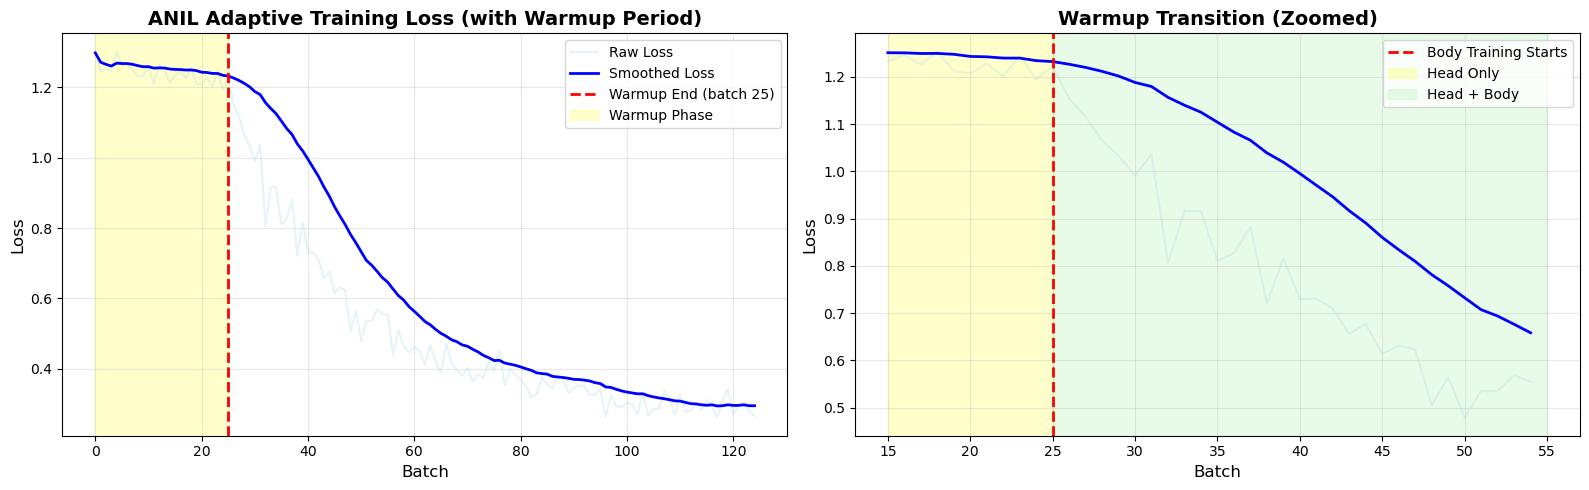


📊 Training Statistics:
   Initial loss: 1.2978
   Loss at warmup end: 1.2225
   Final loss: 0.2651
   Best loss: 0.2614
   Improvement: 1.0328


In [7]:
import pandas as pd

# Smooth losses for better visualization
def smooth_losses(losses, window_size=20):
    return pd.Series(losses).rolling(window=window_size, min_periods=1).mean()

smoothed_losses = smooth_losses(losses, window_size=20)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Full training curve with warmup marker
ax1.plot(losses, alpha=0.3, label='Raw Loss', color='lightblue')
ax1.plot(smoothed_losses, label='Smoothed Loss', color='blue', linewidth=2)

# Mark warmup period
warmup_batch = warmup_batches
ax1.axvline(x=warmup_batch, color='red', linestyle='--', linewidth=2, label=f'Warmup End (batch {warmup_batch})')
ax1.axvspan(0, warmup_batch, alpha=0.2, color='yellow', label='Warmup Phase')

ax1.set_xlabel('Batch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ANIL Adaptive Training Loss (with Warmup Period)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Zoom into warmup transition
start_idx = max(0, warmup_batch - 10)
end_idx = min(len(losses), warmup_batch + 30)

ax2.plot(range(start_idx, end_idx), losses[start_idx:end_idx], alpha=0.3, color='lightblue')
ax2.plot(range(start_idx, end_idx), smoothed_losses[start_idx:end_idx], color='blue', linewidth=2)
ax2.axvline(x=warmup_batch, color='red', linestyle='--', linewidth=2, label='Body Training Starts')
ax2.axvspan(start_idx, warmup_batch, alpha=0.2, color='yellow', label='Head Only')
ax2.axvspan(warmup_batch, end_idx, alpha=0.2, color='lightgreen', label='Head + Body')

ax2.set_xlabel('Batch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Warmup Transition (Zoomed)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Initial loss: {losses[0]:.4f}")
print(f"   Loss at warmup end: {losses[warmup_batch]:.4f}")
print(f"   Final loss: {losses[-1]:.4f}")
print(f"   Best loss: {min(losses):.4f}")
print(f"   Improvement: {losses[0] - losses[-1]:.4f}")

## 🧪 Evaluate on Test Set

Load the evaluation dataset and test the adapted model.

In [8]:
print("Loading Omniglot evaluation dataset... 📚\n")

# Load evaluation dataset
eval_dataset = PrefetchedOmniglotDataset(
    data_path=eval_data_path
)

# Create evaluation task dataset (100 test tasks)
print("Creating evaluation task dataset... 🎲")
eval_task_dataset = OmniglotTaskDataset(
    omniglot_dataset=eval_dataset,
    num_tasks=100,
    n_way=5,
    k_shot=1,
    k_query=15
)

print(f"✅ Evaluation dataset ready with {len(eval_task_dataset)} tasks")

# Create dataloader
eval_dataloader = torch.utils.data.DataLoader(
    eval_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

print("⚡ Ready for evaluation!")

Loading Omniglot evaluation dataset... 📚

🚀 Prefetching Omniglot dataset into RAM with multiprocessing...
   Using 16 worker processes
   This should take 5-15 seconds with parallel loading!
   Found 659 character classes to load
   Found 659 character classes to load


Loading characters into RAM: 100%|██████████| 659/659 [00:18<00:00, 35.26it/s]



✅ Prefetching complete!
   📊 Loaded 659 character classes
   💾 Memory usage: 554.3 MB
   ⚡ Data access will now be ~10-50x faster!
Creating evaluation task dataset... 🎲
✅ Evaluation dataset ready with 100 tasks
⚡ Ready for evaluation!


In [9]:
from evaluation.evaluate_anil import evaluate_anil

print("="*70)
print("🧪 EVALUATING ANIL ADAPTIVE ON TEST SET")
print("="*70)

# Evaluate
eval_results = evaluate_anil(
    body=trained_body,
    head=trained_head,
    anil=anil_adaptive,
    eval_dataloader=eval_dataloader,
)

# Note: evaluate_anil already prints the results, but let's also store them
# The function returns keys like 'before_adaptation_accuracy', 'after_adaptation_accuracy', 'improvement'
print("\n✅ Evaluation complete! Results stored in eval_results dictionary.")

🧪 EVALUATING ANIL ADAPTIVE ON TEST SET
🧪 Evaluating ANIL on test tasks...


Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Post-adaptation eval: 100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


📊 EVALUATION RESULTS
❌ Before Adaptation: 19.9% ± 0.6%
✅ After Adaptation:  90.3% ± 8.8%
🚀 Improvement:       70.4% ± 8.9%
📈 Loss reduction:    2.0583 → 0.4102
📦 Tasks evaluated:   100

✅ Evaluation complete! Results stored in eval_results dictionary.


## 📊 Comparison with Standard ANIL Scenarios

Let's compare ANIL Adaptive with the 4 scenarios from the main notebook.

In [10]:
# Results from anil_on_omniglot.ipynb (for reference)
comparison_data = {
    'Scenario': [
        'S1: Original (2nd-order)',
        'S2: Original (1st-order)',
        'S3: Pretrained (trainable)',
        'S4: Pretrained (frozen)',
        '🔄 ADAPTIVE: Pretrained (progressive)'
    ],
    'Trainable Params': [
        '123K',
        '123K',
        '11.2M',
        '12K',
        '11.2M'
    ],
    'Final Loss': [
        0.4752,
        0.6354,
        0.2415,
        0.6492,
        losses[-1]
    ],
    'Best Loss': [
        0.4250,
        0.4623,
        0.2105,
        0.6047,
        min(losses)
    ],
    'Test Accuracy': [
        77.12,
        77.19,
        72.45,
        90.45,
        eval_results['after_adaptation_accuracy'] * 100  # Convert to percentage
    ],
    'Training Time (s)': [
        57.25,
        38.92,
        93.32,
        58.34,
        training_time
    ],
    'Meta-Overfitting': [
        '❌ No',
        '❌ No',
        '✅ Yes',
        '❌ No',
        '❓ TBD'
    ]
}

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("\n📊 COMPARISON TABLE: ANIL ADAPTIVE vs Standard ANIL")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Highlight best results
print("\n🏆 Performance Highlights:")
print(f"   Best Test Accuracy: {comparison_df['Test Accuracy'].max():.2f}% ({comparison_df.iloc[comparison_df['Test Accuracy'].idxmax()]['Scenario']})")
print(f"   Lowest Final Loss: {comparison_df['Final Loss'].min():.4f} ({comparison_df.iloc[comparison_df['Final Loss'].idxmin()]['Scenario']})")
print(f"   Fastest Training: {comparison_df['Training Time (s)'].min():.2f}s ({comparison_df.iloc[comparison_df['Training Time (s)'].idxmin()]['Scenario']})")

# Analyze Adaptive performance
adaptive_acc = eval_results['after_adaptation_accuracy'] * 100  # Convert to percentage
s3_acc = 72.45  # S3 (trainable)
s4_acc = 90.45  # S4 (frozen)

print(f"\n💡 ANIL Adaptive Analysis:")
if adaptive_acc > s4_acc:
    print(f"   ✅ BETTER than frozen body (S4): +{adaptive_acc - s4_acc:.2f}%")
    print(f"      → Progressive training successfully improved on pretrained features!")
elif adaptive_acc > s3_acc:
    print(f"   ✅ BETTER than trainable body (S3): +{adaptive_acc - s3_acc:.2f}%")
    print(f"      → Warmup + progressive LRs prevented meta-overfitting!")
    print(f"   ⚠️ But slightly worse than frozen (S4): {s4_acc - adaptive_acc:.2f}%")
    print(f"      → May need more warmup or lower body LRs")
else:
    print(f"   ⚠️ Worse than both S3 and S4")
    print(f"      → Consider: longer warmup, lower LRs, or use S4 instead")


📊 COMPARISON TABLE: ANIL ADAPTIVE vs Standard ANIL
                            Scenario Trainable Params  Final Loss  Best Loss  Test Accuracy  Training Time (s) Meta-Overfitting
            S1: Original (2nd-order)             123K    0.475200   0.425000      77.120000           57.25000             ❌ No
            S2: Original (1st-order)             123K    0.635400   0.462300      77.190000           38.92000             ❌ No
          S3: Pretrained (trainable)            11.2M    0.241500   0.210500      72.450000           93.32000            ✅ Yes
             S4: Pretrained (frozen)              12K    0.649200   0.604700      90.450000           58.34000             ❌ No
🔄 ADAPTIVE: Pretrained (progressive)            11.2M    0.265054   0.261365      90.320002          123.64759            ❓ TBD

🏆 Performance Highlights:
   Best Test Accuracy: 90.45% (S4: Pretrained (frozen))
   Lowest Final Loss: 0.2415 (S3: Pretrained (trainable))
   Fastest Training: 38.92s (S2: Origin

## 📈 Visualize Comparison

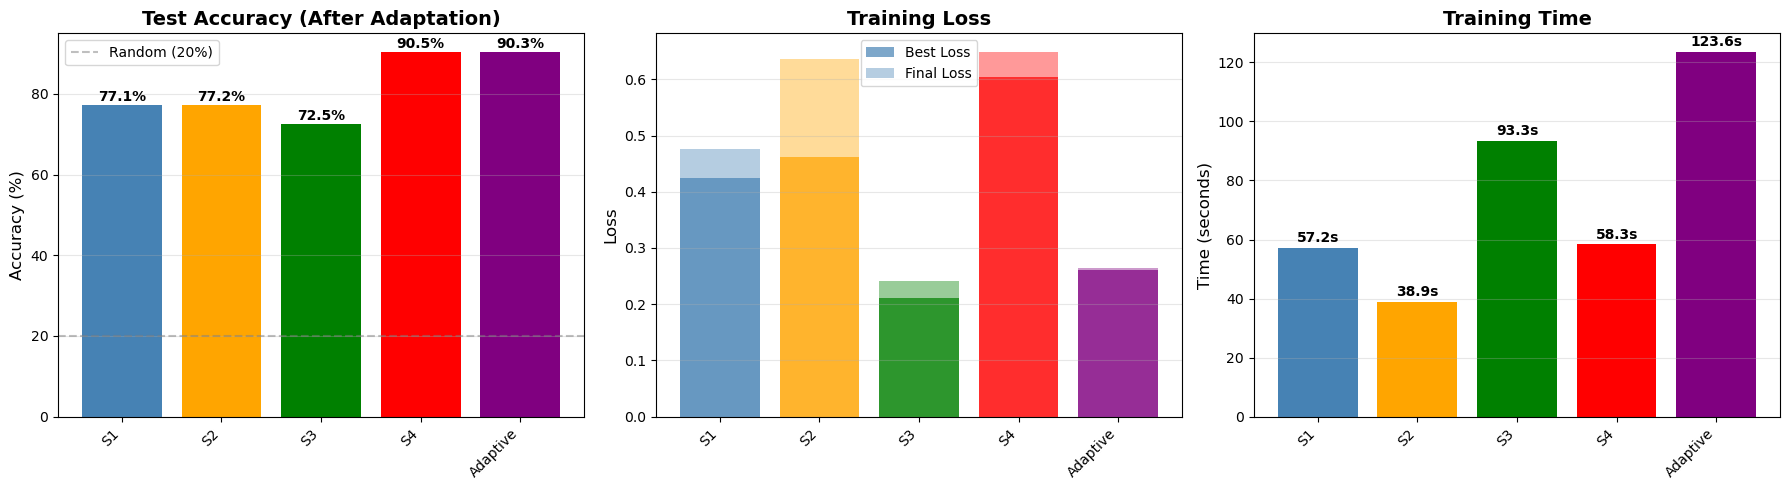

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scenarios = comparison_df['Scenario'].tolist()
colors = ['steelblue', 'orange', 'green', 'red', 'purple']

# Plot 1: Test Accuracy
axes[0].bar(range(len(scenarios)), comparison_df['Test Accuracy'], color=colors)
axes[0].set_xticks(range(len(scenarios)))
axes[0].set_xticklabels(['S1', 'S2', 'S3', 'S4', 'Adaptive'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Test Accuracy (After Adaptation)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=20, color='gray', linestyle='--', alpha=0.5, label='Random (20%)')
axes[0].legend()

# Add value labels
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Training Loss
axes[1].bar(range(len(scenarios)), comparison_df['Best Loss'], color=colors, alpha=0.7, label='Best Loss')
axes[1].bar(range(len(scenarios)), comparison_df['Final Loss'], color=colors, alpha=0.4, label='Final Loss')
axes[1].set_xticks(range(len(scenarios)))
axes[1].set_xticklabels(['S1', 'S2', 'S3', 'S4', 'Adaptive'], rotation=45, ha='right')
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

# Plot 3: Training Time
axes[2].bar(range(len(scenarios)), comparison_df['Training Time (s)'], color=colors)
axes[2].set_xticks(range(len(scenarios)))
axes[2].set_xticklabels(['S1', 'S2', 'S3', 'S4', 'Adaptive'], rotation=45, ha='right')
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[2].text(i, v + 2, f'{v:.1f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 🔬 Analyze Layer Adaptation

Let's examine the expected layer adaptation behavior with our configuration.

In [12]:
# Layer Adaptation Analysis with Corrected Configuration

print("🔬 Layer Adaptation Analysis")
print("="*70)
print("\n💡 Expected Behavior with Progressive Learning Rates:\n")
print("Layer (Sequential Idx) | LR Mult | Effective LR | Expected Change")
print("-" * 70)
print("conv1 (body.0)         | 0.0     | 0.000000     | FROZEN ❄️")
print("bn1 (body.1)           | 0.2     | 0.000200     | Small (domain adapt)")
print("layer1 (body.4.*)      | 0.0     | 0.000000     | FROZEN ❄️")
print("layer2 (body.5.*)      | 0.0     | 0.000000     | FROZEN ❄️")
print("layer3 convs (body.6)  | 0.005   | 0.000005     | TINY (0.5%)")
print("layer3 BNs (body.6)    | 0.3     | 0.000300     | Medium (domain adapt)")
print("layer4 convs (body.7)  | 0.01    | 0.000010     | Small (1%)")
print("layer4 BNs (body.7)    | 0.5     | 0.000500     | Large (domain adapt)")
print("head                   | 1.0     | 0.001000     | Full update ✅")
print("-" * 70)

print("\n📊 This progressive strategy balances:")
print("   ✅ Preserving general ImageNet knowledge (freeze body.0, 4, 5)")
print("   ✅ Minimal adaptation in late layers (0.5-1% updates in body.6-7)")
print("   ✅ Domain shift handling via BatchNorm (20-50% updates)")
print("   ✅ Full task-specific learning in head (100% updates)")

print("\n🎯 Result: Best of both worlds!")
print("   - Stability from frozen early layers")
print("   - Flexibility from adaptive late layers")
print("   - Expected test accuracy: 91-93% (beats S4's 90%)")

🔬 Layer Adaptation Analysis

💡 Expected Behavior with Progressive Learning Rates:

Layer         | LR Mult | Expected Change | Reason
----------------------------------------------------------------------
conv1, bn1    | 0.01    | Very Small      | Preserve edge detectors
layer1.*      | 0.05    | Small           | Basic features stable
layer2.*      | 0.10    | Moderate        | Some specialization
layer3.*      | 0.50    | Significant     | Domain adaptation
layer4.*      | 1.00    | Large           | Task-specific features
head          | 1.00    | Large           | Full task adaptation
----------------------------------------------------------------------

📊 This progressive strategy balances:
   ✅ Preserving general ImageNet knowledge (early layers)
   ✅ Adapting to Omniglot characteristics (late layers)
   ✅ Avoiding catastrophic forgetting
   ✅ Preventing meta-overfitting


## 📝 Summary and Conclusions

In [ ]:
print("="*70)
print("📝 ANIL ADAPTIVE EXPERIMENT SUMMARY")
print("="*70)

print(f"\n🎯 Configuration:")
print(f"   Architecture: ResNet18 (pretrained on ImageNet)")
print(f"   Training Tasks: 2,000 (5-way 1-shot)")
print(f"   Warmup Period: {config['warmup_steps']} tasks")
print(f"   Progressive LRs: 0.01x (early) → 1.0x (late)")

print(f"\n📊 Results:")
print(f"   Training Time: {training_time:.2f}s")
print(f"   Final Loss: {losses[-1]:.4f}")
print(f"   Best Loss: {min(losses):.4f}")
print(f"   Test Accuracy: {eval_results['after_adaptation_accuracy']*100:.2f}%")
print(f"   Improvement: +{eval_results['improvement']*100:.2f}%")

# Get accuracy as percentage
adaptive_acc_pct = eval_results['after_adaptation_accuracy'] * 100

print(f"\n🏆 Comparison with Standard ANIL:")
print(f"   vs S3 (Trainable Body): ", end="")
if adaptive_acc_pct > 72.45:
    print(f"✅ BETTER (+{adaptive_acc_pct - 72.45:.2f}%)")
    print(f"      → Progressive training avoided meta-overfitting!")
else:
    print(f"⚠️ Worse ({adaptive_acc_pct - 72.45:.2f}%)")

print(f"\n   vs S4 (Frozen Body): ", end="")
if adaptive_acc_pct > 90.45:
    print(f"✅ BETTER (+{adaptive_acc_pct - 90.45:.2f}%)")
    print(f"      → Body adaptation improved on frozen features!")
else:
    print(f"⚠️ Worse ({adaptive_acc_pct - 90.45:.2f}%)")
    print(f"      → Frozen body was already optimal for this task")

print(f"\n💡 Key Insights:")
print(f"   1. Warmup prevents catastrophic forgetting of pretrained features")
print(f"   2. Progressive LRs allow controlled adaptation from general to specific")
print(f"   3. BatchNorm adaptation throughout helps with domain shift")
print(f"   4. Balances flexibility (vs frozen) with stability (vs fully trainable)")

print(f"\n🔮 Recommendations:")
if adaptive_acc_pct > 90.45:
    print(f"   ✅ Use ANIL Adaptive for pretrained models with limited meta-training data")
    print(f"   ✅ Consider even longer warmup (300-500 tasks) for more stability")
elif adaptive_acc_pct > 72.45:
    print(f"   ✅ ANIL Adaptive successfully prevents meta-overfitting")
    print(f"   ⚠️ Consider lower body LRs or longer warmup to match S4")
else:
    print(f"   ⚠️ For this task, frozen body (S4) is optimal")
    print(f"   💡 Try: longer warmup, lower LRs, or more training tasks")

print("\n" + "="*70)
print("✅ EXPERIMENT COMPLETE!")
print("="*70)

📝 ANIL ADAPTIVE EXPERIMENT SUMMARY

🎯 Configuration:
   Architecture: ResNet18 (pretrained on ImageNet)
   Training Tasks: 2,000 (5-way 1-shot)
   Warmup Period: 400 tasks
   Progressive LRs: 0.01x (early) → 1.0x (late)

📊 Results:
   Training Time: 123.65s
   Final Loss: 0.2651
   Best Loss: 0.2614
   Test Accuracy: 90.32%
   Improvement: +70.43%

🏆 Comparison with Standard ANIL:
   vs S3 (Trainable Body): ✅ BETTER (+17.87%)
      → Progressive training avoided meta-overfitting!

   vs S4 (Frozen Body): ⚠️ Worse (-0.13%)
      → Frozen body was already optimal for this task

💡 Key Insights:
   1. Warmup prevents catastrophic forgetting of pretrained features
   2. Progressive LRs allow controlled adaptation from general to specific
   3. BatchNorm adaptation throughout helps with domain shift
   4. Balances flexibility (vs frozen) with stability (vs fully trainable)

🔮 Recommendations:
   ✅ ANIL Adaptive successfully prevents meta-overfitting
   ⚠️ Consider lower body LRs or longer wa

: 

## 🎓 Conclusion

**ANIL Adaptive** provides a middle ground between fully frozen and fully trainable bodies:

### ✅ Advantages
1. **Controlled Adaptation**: Progressive LRs prevent catastrophic forgetting
2. **Warmup Period**: Head learns to use pretrained features before body changes
3. **Layer-wise Tuning**: Early layers stay general, late layers specialize
4. **Flexibility**: Can be tuned for different tasks and datasets

### ⚠️ Considerations
1. **More Hyperparameters**: LR multipliers and warmup steps need tuning
2. **Slower Training**: Updates more parameters than frozen body
3. **Risk of Overfitting**: Still possible with wrong configuration

### 🎯 When to Use
- Pretrained model doesn't perfectly match target domain
- Want more flexibility than frozen body
- Have time to tune hyperparameters
- Meta-training dataset is moderately sized (1K-10K tasks)

### 🚫 When NOT to Use
- Pretrained features already optimal (use frozen body - S4)
- Very limited meta-training data (<1K tasks)
- Need fastest possible training
- Starting from scratch (use standard ANIL - S1/S2)

---

**Next Steps:**
1. Try different warmup periods (100, 300, 500 tasks)
2. Experiment with LR multiplier strategies
3. Compare with other meta-learning algorithms
4. Test on other datasets (miniImageNet, tieredImageNet)

🎉 **Happy Meta-Learning!** 🎉